In [1]:
import os 

import affine
import numpy as np
import rasterio
from xcube.core.store import new_data_store
from xcube.core.geom import clip_dataset_by_geometry
from xcube.core.maskset import MaskSet
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
s3_store = new_data_store(
    "s3",
    root=os.environ["S3_USER_STORAGE_BUCKET"],
    max_depth=10,
    storage_options=dict(
        anon=False,
        key=os.environ["S3_USER_STORAGE_KEY"],
        secret=os.environ["S3_USER_STORAGE_SECRET"],
    ),
)

In [3]:
store_lccs = new_data_store("s3", root="deep-esdl-public")

In [4]:
cube = s3_store.open_data("cubes/training/0.2.0/0000_0.zarr")
cube

<xarray.Dataset> Size: 54MB
Dimensions:                   (time: 132, y: 90, x: 90, time_era5: 367,
                               time_lccs: 3, band: 12, angle: 2, angle_y: 2,
                               angle_x: 2)
Coordinates:
  * angle                     (angle) <U7 56B 'Zenith' 'Azimuth'
  * angle_x                   (angle_x) float64 16B 4.831e+05 4.881e+05
  * angle_y                   (angle_y) float64 16B 6.769e+06 6.764e+06
  * band                      (band) <U3 144B 'B01' 'B02' 'B03' ... 'B11' 'B12'
    spatial_ref               int64 8B ...
  * time                      (time) datetime64[ns] 1kB 2019-02-10T10:52:09.0...
  * time_era5                 (time_era5) datetime64[ns] 3kB 2019-02-10 ... 2...
  * time_lccs                 (time_lccs) datetime64[ns] 24B 2019-01-01 ... 2...
  * x                         (x) float64 720B 4.831e+05 4.831e+05 ... 4.84e+05
  * y                         (y) float64 720B 6.765e+06 6.765e+06 ... 6.764e+06
Data variables: (12/118)
    cloud_mask                (time, y, x) uint8 1MB dask.array<chunksize=(20, 90, 90), meta=np.ndarray>
    dem                       (y, x) float32 32kB dask.array<chunksize=(90, 90), meta=np.ndarray>
    era5_d2m_max              (time_era5) float32 1kB dask.array<chunksize=(367,), meta=np.ndarray>
    era5_d2m_mean             (time_era5) float32 1kB dask.array<chunksize=(367,), meta=np.ndarray>
    era5_d2m_median           (time_era5) float32 1kB dask.array<chunksize=(367,), meta=np.ndarray>
    era5_d2m_min              (time_era5) float32 1kB dask.array<chunksize=(367,), meta=np.ndarray>
    ...                        ...
    lccs_observation_count    (time_lccs, y, x) uint16 49kB dask.array<chunksize=(3, 90, 90), meta=np.ndarray>
    lccs_processed_flag       (time_lccs, y, x) float32 97kB dask.array<chunksize=(3, 90, 90), meta=np.ndarray>
    s2l2a                     (band, time, y, x) float32 51MB dask.array<chunksize=(12, 20, 90, 90), meta=np.ndarray>
    scl                       (time, y, x) uint8 1MB dask.array<chunksize=(20, 90, 90), meta=np.ndarray>
    solar_angle               (angle, time, angle_y, angle_x) float32 4kB dask.array<chunksize=(2, 20, 2, 2), meta=np.ndarray>
    viewing_angle             (angle, band, time, angle_y, angle_x) float32 51kB dask.array<chunksize=(2, 12, 20, 2, 2), meta=np.ndarray>
Attributes: (12/24)
    Conventions:                  CF-1.8
    acknowledgment:               DeepFeatures project
    affine_transform:             [10.0, 0.0, 483100.0, 0.0, -10.0, 6764670.0...
    bbox_utm:                     [483105, 6763767, 484005.0, 6764667.0]
    bbox_wgs84:                   [8.687542498125213, 61.008433434467456, 8.7...
    center_utm:                   [6764217.840459977, 483555.3977439079]
    ...                           ...
    last_modified_datetime:       2025-08-27T08:48:18.629435
    project:                      DeepFeatures
    time_range_end:               2020-02-10T10:52:01.024000
    time_range_start:             2019-02-10T10:52:09.024000
    utm_zone:                     32V
    version:                      0.2.0

In [5]:
mlds_lc = store_lccs.open_data("LC-1x2025x2025-2.0.0.levels")
lc = mlds_lc.base_dataset

# clip LC dataset by data cube geometry
buffer = 0.01
bbox = cube.attrs["bbox_wgs84"]
bbox = [bbox[0] - buffer, bbox[1] - buffer, bbox[2] + buffer, bbox[3] + buffer]
lc = clip_dataset_by_geometry(lc, bbox)
start = cube.time[0] - np.timedelta64(365, "D")
end = cube.time[-1] + np.timedelta64(365, "D")
lc = lc.sel(time=slice(start, end))
lc

<xarray.Dataset> Size: 7kB
Dimensions:              (time: 3, lat: 11, lon: 15, bounds: 2)
Coordinates:
  * lat                  (lat) float64 88B 61.03 61.03 61.02 ... 61.01 61.0 61.0
  * lon                  (lon) float64 120B 8.676 8.679 8.682 ... 8.713 8.715
  * time                 (time) datetime64[ns] 24B 2019-01-01 ... 2021-01-01
Dimensions without coordinates: bounds
Data variables:
    change_count         (time, lat, lon) uint8 495B dask.array<chunksize=(1, 11, 15), meta=np.ndarray>
    crs                  int32 4B ...
    current_pixel_state  (time, lat, lon) float32 2kB dask.array<chunksize=(1, 11, 15), meta=np.ndarray>
    lat_bounds           (lat, bounds) float64 176B dask.array<chunksize=(11, 2), meta=np.ndarray>
    lccs_class           (time, lat, lon) uint8 495B dask.array<chunksize=(1, 11, 15), meta=np.ndarray>
    lon_bounds           (lon, bounds) float64 240B dask.array<chunksize=(15, 2), meta=np.ndarray>
    observation_count    (time, lat, lon) uint16 990B dask.array<chunksize=(1, 11, 15), meta=np.ndarray>
    processed_flag       (time, lat, lon) float32 2kB dask.array<chunksize=(1, 11, 15), meta=np.ndarray>
    time_bounds          (time, bounds) datetime64[ns] 48B dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/41)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((8.67500000138891 61, 8.6750000013889...
    date_modified:              2025-08-27T09:42:01.489051

In [6]:
lc.rio.write_crs(lc.crs.attrs["wkt"], inplace=True)
lc = lc.rename(dict(lon="x", lat="y"))
lc = lc.drop_vars(["lat_bounds", "lon_bounds", "time_bounds", "crs"])
lc_reproject = lc.rio.reproject(
    f"EPSG:326{cube.attrs['utm_zone'][:2]}",
    shape=(cube.sizes["y"], cube.sizes["x"]),
    transform=affine.Affine(*cube.attrs["affine_transform"]),
    resampling=rasterio.enums.Resampling.nearest,
)
lc_reproject

<xarray.Dataset> Size: 293kB
Dimensions:              (x: 90, y: 90, time: 3)
Coordinates:
  * x                    (x) float64 720B 4.831e+05 4.831e+05 ... 4.84e+05
  * y                    (y) float64 720B 6.765e+06 6.765e+06 ... 6.764e+06
  * time                 (time) datetime64[ns] 24B 2019-01-01 ... 2021-01-01
    spatial_ref          int64 8B 0
Data variables:
    change_count         (time, y, x) uint8 24kB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    current_pixel_state  (time, y, x) float32 97kB 1.0 1.0 1.0 ... 1.0 1.0 1.0
    lccs_class           (time, y, x) uint8 24kB 70 70 70 70 ... 150 150 150 150
    observation_count    (time, y, x) uint16 49kB 31 31 31 31 31 ... 24 24 24 24
    processed_flag       (time, y, x) float32 97kB 1.0 1.0 1.0 ... 1.0 1.0 1.0
Attributes: (12/41)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((8.67500000138891 61, 8.6750000013889...
    date_modified:              2025-08-27T09:42:01.489051

In [7]:
land_cover_mask = MaskSet(lc.lccs_class)
land_cover_mask

Flag name,Mask,Value
no_data,None,0
cropland_rainfed,None,10
cropland_rainfed_herbaceous_cover,None,11
cropland_rainfed_tree_or_shrub_cover,None,12
cropland_irrigated,None,20
mosaic_cropland,None,30
mosaic_natural_vegetation,None,40
tree_broadleaved_evergreen_closed_to_open,None,50
tree_broadleaved_deciduous_closed_to_open,None,60
tree_broadleaved_deciduous_closed,None,61


Text(0.5, 1.0, 'Reprojected LC')

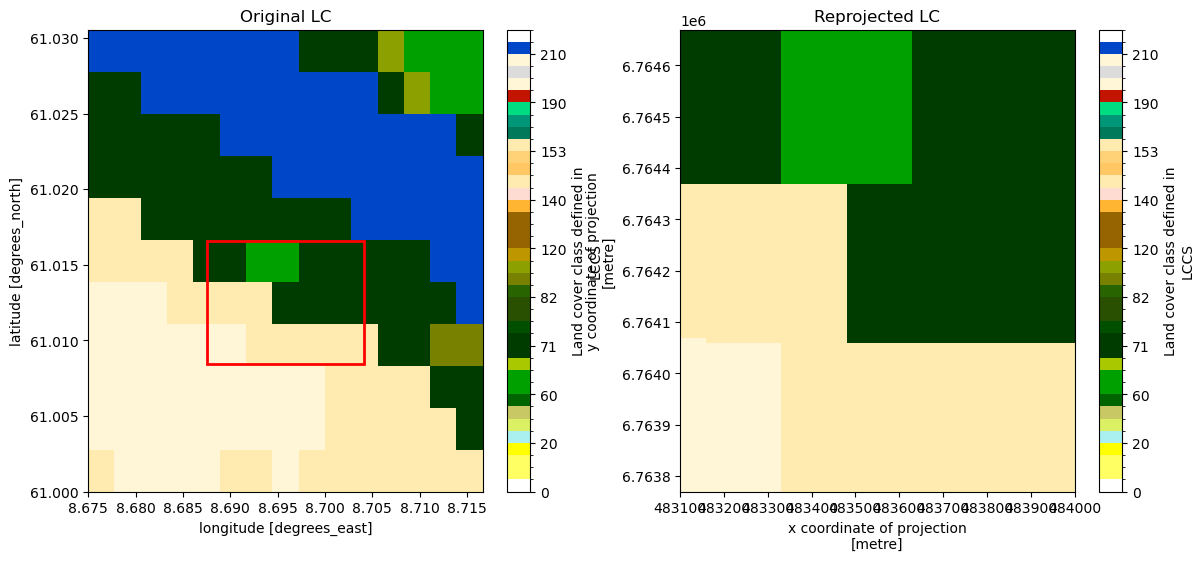

In [8]:
cmap, norm = land_cover_mask.get_cmap()

# Create side-by-side axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot
lc_plot = lc.lccs_class.isel(time=0).plot(
    cmap=cmap, norm=norm, ax=axes[0]
)

min_lon, min_lat, max_lon, max_lat = cube.attrs["bbox_wgs84"]
rect = patches.Rectangle(
    (min_lon, min_lat),
    max_lon - min_lon,
    max_lat - min_lat,
    linewidth=2,
    edgecolor='red',
    facecolor='none'
)
axes[0].add_patch(rect)
axes[0].set_title("Original LC")

# Second plot
lc_reproject.lccs_class.isel(time=0).plot(
    cmap=cmap, norm=norm, ax=axes[1]
)
axes[1].set_title("Reprojected LC")